In [1]:
import os
import random
import numpy as np
import jax
import flax.linen as nn
from jax import grad, value_and_grad
import jax.numpy as jnp
import optax
import datasets
from datasets import load_dataset
import matplotlib.pyplot as plt

from colormap import create_ade20k_label_colormap

In [2]:
dataset = load_dataset("scene_parse_150")
train_dataset, test_dataset, val_dataset  = dataset["train"], dataset["test"], dataset["validation"]
# Number of segmentation classes
num_classes = 151
# Image height and width
height, width = 256, 256

  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
class _unet(nn.Module):
    num_classes: int

    @nn.compact
    def __call__(self, x):
        ########################### Encoders ############################
        # Encoder block 1
        encoder_block1 = nn.Sequential([
            nn.Conv(features=64, kernel_size=(3, 3), padding="SAME"), jax.nn.relu,
            nn.Conv(features=64, kernel_size=(3, 3), padding="SAME"), jax.nn.relu,
        ])
        encoder1 = encoder_block1(x)
        x = encoder1
        x = nn.max_pool(inputs=x, window_shape=(2, 2), strides=(2, 2), padding="SAME")
        # Encoder block 2
        encoder_block2 = nn.Sequential([
            nn.Conv(features=128, kernel_size=(3, 3), padding="SAME"), jax.nn.relu,
            nn.Conv(features=128, kernel_size=(3, 3), padding="SAME"), jax.nn.relu,
        ])
        encoder2 = encoder_block2(x)
        x = encoder2
        x = nn.max_pool(inputs=x, window_shape=(2, 2), strides=(2, 2), padding="SAME")
        # Encoder block 3
        encoder_block3 = nn.Sequential([
            nn.Conv(features=256, kernel_size=(3, 3), padding="SAME"), jax.nn.relu,
            nn.Conv(features=256, kernel_size=(3, 3), padding="SAME"), jax.nn.relu,
        ])
        encoder3 = encoder_block3(x)
        x = encoder3
        x = nn.max_pool(inputs=x, window_shape=(2, 2), strides=(2, 2), padding="SAME")
        # Encoder block 4
        encoder_block4 = nn.Sequential([
            nn.Conv(features=512, kernel_size=(3, 3), padding="SAME"), jax.nn.relu,
            nn.Conv(features=512, kernel_size=(3, 3), padding="SAME"), jax.nn.relu,
        ])
        encoder4 = encoder_block4(x)
        x = encoder4
        x = nn.max_pool(inputs=x, window_shape=(2, 2), strides=(2, 2), padding="SAME")
        # Encoder block 5
        encoder_block5 = nn.Sequential([
            nn.Conv(features=1024, kernel_size=(3, 3), padding="SAME"), jax.nn.relu,
            nn.Conv(features=1024, kernel_size=(3, 3), padding="SAME"), jax.nn.relu,
        ])
        x = encoder_block5(x)


        ########################### Decoders ############################
        # Decoder block 4
        x = nn.ConvTranspose(features=512, kernel_size=(2, 2), strides=(2, 2), padding="SAME")(x)
        x = jax.nn.relu(x)
        x = jnp.concatenate((x, encoder4), axis=-1)
        decoder_block3 = nn.Sequential([
            nn.Conv(features=512, kernel_size=(3, 3), padding="SAME"), jax.nn.relu,   
            nn.Conv(features=512, kernel_size=(3, 3), padding="SAME"), jax.nn.relu, 
        ])  
        x = decoder_block3(x)    
        # Decoder block 3
        x = nn.ConvTranspose(features=256, kernel_size=(2, 2), strides=(2, 2), padding="SAME")(x)
        x = jax.nn.relu(x)
        x = jnp.concatenate((x, encoder3), axis=-1)
        decoder_block3 = nn.Sequential([
            nn.Conv(features=256, kernel_size=(3, 3), padding="SAME"), jax.nn.relu,   
            nn.Conv(features=256, kernel_size=(3, 3), padding="SAME"), jax.nn.relu, 
        ])  
        x = decoder_block3(x)  
        # Decoder block 2
        x = nn.ConvTranspose(features=128, kernel_size=(2, 2), strides=(2, 2), padding="SAME")(x)
        x = jax.nn.relu(x)
        x = jnp.concatenate((x, encoder2), axis=-1)
        decoder_block2 = nn.Sequential([
            nn.Conv(features=128, kernel_size=(3, 3), padding="SAME"), jax.nn.relu,   
            nn.Conv(features=128, kernel_size=(3, 3), padding="SAME"), jax.nn.relu, 
        ])  
        x = decoder_block2(x)  
        # Decoder block 1
        x = nn.ConvTranspose(features=64, kernel_size=(2, 2), strides=(2, 2), padding="SAME")(x)
        x = jax.nn.relu(x)
        x = jnp.concatenate((x, encoder1), axis=-1)
        decoder_block1 = nn.Sequential([
            nn.Conv(features=64, kernel_size=(3, 3), padding="SAME"), jax.nn.relu,   
            nn.Conv(features=64, kernel_size=(3, 3), padding="SAME"), jax.nn.relu, 
            nn.Conv(features=self.num_classes, kernel_size=(1, 1), padding="SAME"), jax.nn.sigmoid,
        ])  
        x = decoder_block1(x)  

        return x

# Create the model object
unet = _unet(num_classes)
# Display the model details
dummy_x = np.array(train_dataset[0]["image"])
# Downsample the image
dummy_x = jax.image.resize(dummy_x, shape=(height, width, 3), method="bilinear")
rng_key = jax.random.PRNGKey(64)
print(unet.tabulate(rng_key, dummy_x))


                                 _unet Summary                                  
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ path          ┃ module        ┃ inputs        ┃ outputs       ┃ params       ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│               │ _unet         │ float32[256,… │ float32[256,… │              │
├───────────────┼───────────────┼───────────────┼───────────────┼──────────────┤
│ Sequential_0  │ Sequential    │ float32[256,… │ float32[256,… │              │
├───────────────┼───────────────┼───────────────┼───────────────┼──────────────┤
│ Conv_0        │ Conv          │ float32[256,… │ float32[256,… │ bias:        │
│               │               │               │               │ float32[64]  │
│               │               │               │               │ kernel:      │
│               │               │               │               │ float32[3,3… │
│               │          

In [4]:
def binarize_target(target_ids, num_classes):
    """
    Converts a single array of target IDs to binary form.
    Each ID will be represented in a seperate channel.
    Args:
        target_ids: A single array of class IDs, 
            with values between 0 and num_classes.
        num_classes: Total number of distinct classes.
    Returns:
        A binarized array of class IDs. 
    """
    (dim_x, dim_y) = target_ids.shape
    binary_labels = np.zeros(shape=(dim_x, dim_y, num_classes))
    for class_id in range(num_classes):
        binary_labels[:, :, class_id] = target_ids == class_id
    return jnp.array(binary_labels)


In [5]:
def prep_data(data, height, width, num_classes):
    """
    Prepares the data by resizing to the requested height/width and
    binarizing the target ID's.
    Args:
        data: Dictionary containing a single input image and annotation.
        height: Height dimension for resizing the images.
        width: Width dimension for resizing the images.
        num_classes: Total number of distinct classes.
    Returns:
        The resized input image and resized binarized target ID's.
    """
    input, target_ids = jnp.array(data["image"][0]), np.array(data["annotation"][0])
    target_ids_binary = binarize_target(target_ids, num_classes)
    # Downsample the image
    input = jax.image.resize(input, shape=(height, width, 3), method="bilinear")
    target_ids_binary = jax.image.resize(target_ids_binary, shape=(height, width, num_classes), method="nearest")
    return input, target_ids_binary
    

In [6]:
def prep_data_batch(data_generator, batch_size, height, width, num_classes):
    """
    Prepares a batch of data for training/validation.
    Args:
        data_generator: Generator object containing the 
            training/validation data.
        batch_size: Number of data to process in parallel. 
        height: Height dimension for resizing the images.
        width: Width dimension for resizing the images.
        num_classes: Total number of distinct classes.
    Returns:
        A Jax array of input images and target images.
    """
    inputs = []
    targets = []
    for _ in range(batch_size):
        data = next(data_generator)
        input, target_ids_binary = prep_data(data, height, width, num_classes)
        inputs.append(input)
        targets.append(target_ids_binary)
    inputs = jnp.array(inputs)
    targets = jnp.array(targets)
    return inputs, targets

In [7]:
@jax.jit
def dice_loss(variables, inputs, targets, epsilon):
    """
    Calculates the dice loss for a batch of images.
    Args:
        variables: The segmentation models parameters.
        inputs: A batch of raw input images.
        targets: A batch of arrays with the same shape as inputs. Stores the binary
                 classification label for each element in inputs
                (0 for the negative class and 1 for the positive class).
        epsilon: A small number to prevent loss function from dividing by zero.
    Returns:
        The dice loss from a batch of images.
    """
    preds = unet.apply(variables, inputs)
    numerator = 2 * (preds * targets).sum(axis=(-2, -3))
    denominator = preds.sum(axis=(-2, -3)) + targets.sum(axis=(-2, -3))
    loss = 1 - jnp.mean((numerator + epsilon) / (denominator + epsilon))
    return loss

In [8]:
def overlay_seg_mask(image: np.ndarray, binary_mask: np.ndarray):
    """
    Converts the segmentation mask to RGB using the colormap, 
    then overlays the RGB segmentation mask ontop of the image.
    Args:
        image: An RGB image.
        binary_mask: 
    Returns:
        An image with the segmentation mask overlayed on it.
    """

    image = np.squeeze(image)
    binary_mask = np.squeeze(binary_mask)
    color_seg = np.zeros((binary_mask.shape[-3], binary_mask.shape[-2], 3), dtype=np.uint8)
    palette = np.array(create_ade20k_label_colormap())
    for label, color in enumerate(palette):
        color_seg[binary_mask[:, :, label], :] = color
    color_seg = color_seg[..., ::-1]  # convert to BGR

    img = np.array(image) * 0.5 + color_seg * 0.5  # plot the image with the segmentation map
    img = img.astype(np.uint8)
    return img

In [9]:
def plot_pred_and_target(image, pred, target):
    """
    Plots the prediction and target segmentations side-by-side,
    both overlayed on the original image.
    Args:
        image: An RGB image.
        pred:
        target:
    Returns:
        Nothing. Simply plots the image.
    """
    fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
    axs[0].set_title("Prediction")
    pred_overlay = overlay_seg_mask(
        np.array(image),
        np.array(pred, dtype=bool)
    )
    axs[0].imshow(pred_overlay)
    axs[0].axis("off")
    axs[1].set_title("Target")
    target_overlay = overlay_seg_mask(
        np.array(image),
        np.array(target, dtype=bool)
    )
    axs[1].imshow(target_overlay)
    axs[1].axis("off")
    plt.tight_layout()
    plt.show()

Epoch: 0


2023-01-25 19:55:12.222411: W external/org_tensorflow/tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


	Loss: 0.99
		Validation Loss: 0.71


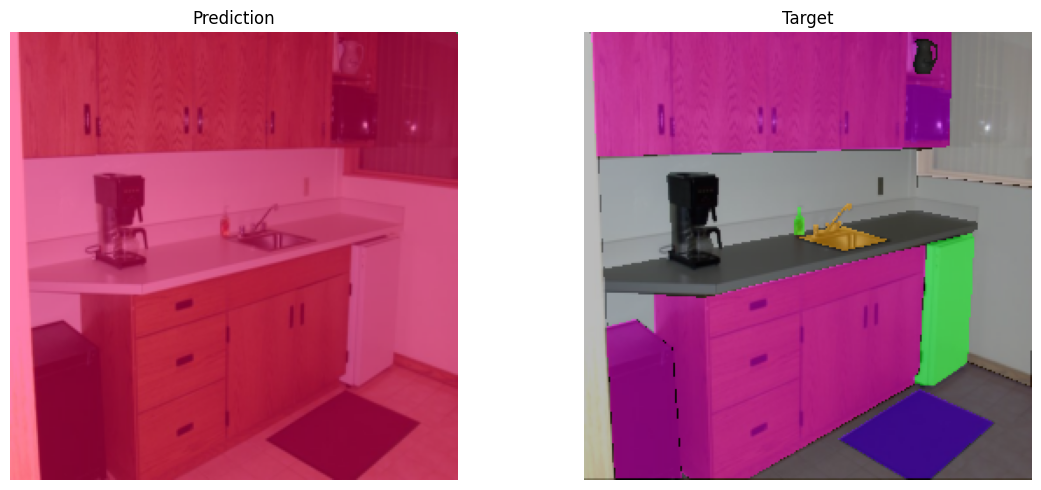

In [10]:
# Number of training epochs
epochs = 50
# Display training loss freq
print_freq = 100
# Validation frequency
val_epochs = 1000
batch_size = 2
# A small number to prevent loss function from dividing by zero
epsilon = 0.0001
# Exponential decay learning rate schedule defined by:
# learning_rate * decay_rate ^ (global_step / decay_steps)
schedule = optax.exponential_decay(
  init_value=0.03,
  transition_steps=100,
  decay_rate=0.99,
  transition_begin=500,
  end_value=0.0001,
)


variables = unet.init(rng_key, dummy_x)
optimizer = optax.adam(learning_rate=schedule)
opt_state = optimizer.init(variables)

train_data_generator = train_dataset.iter(batch_size=1)
val_data_generator = val_dataset.iter(batch_size=1)

losses = []
val_losses = []

for epoch in range(epochs + 1):
    if epoch % print_freq == 0: print(f"Epoch: {epoch}")
    # Prepare a batch of data
    inputs, targets = prep_data_batch(train_data_generator, batch_size, height, width, num_classes)
    # Perform backpropagation 
    loss, grads = value_and_grad(dice_loss, argnums=(0))(variables, inputs, targets, epsilon)
    updates, opt_state = optimizer.update(grads, opt_state, variables)
    variables = optax.apply_updates(variables, updates)

    losses.append(loss)
    if epoch % print_freq == 0: print(f"\tLoss: {loss :.2f}")
    # Evaluate the models performance
    if epoch % val_epochs == 0:
        # Prepare a batch of data
        val_inputs, val_targets = prep_data_batch(val_data_generator, batch_size, height, width, num_classes)
        val_loss = dice_loss(variables, val_inputs, val_targets, epsilon)
        val_losses.append(val_loss)
        print(f"\t\tValidation Loss: {val_loss :.2f}")

        val_input = val_inputs[0]
        val_pred = unet.apply(variables, val_input)
        plot_pred_and_target(val_input, val_pred, val_targets[0])


    

In [ ]:
epoch_window = 5
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
axs[0].set_title("Training Loss")
loss_moving_average = (
    np.convolve(
        np.array(losses), np.ones(epoch_window), mode="valid"
    )
    / epoch_window
)
axs[0].plot(range(len(loss_moving_average)), loss_moving_average)
axs[1].set_title("Validation Loss")
val_loss_moving_average = (
    np.convolve(
        np.array(val_losses), np.ones(epoch_window), mode="valid"
    )
    / epoch_window
)
axs[1].plot(range(len(val_loss_moving_average)), val_loss_moving_average)
plt.tight_layout()
plt.show()